In [1]:
import btrdb
import numpy as np
import pandas as pd
import time
from matplotlib.pyplot import cm

import scipy.signal as sig
from scipy import linalg
from scipy.ndimage.interpolation import shift


from tabulate import tabulate
from btrdb.utils.timez import ns_delta
from btrdb.utils.timez import ns_delta, to_nanoseconds
from btrdb.utils.timez import ns_to_datetime
from btrdb.utils.general import pointwidth

import importlib

# Plotting
import matplotlib.pyplot as plt
#plt.style.use('Solarize_Light2')
plt.style.use('fivethirtyeight')
%matplotlib inline

# BTrDB Setup

In [2]:
# Insert your API key here!
APIKEY='40BB1A78C6525F7445E4E553'

db = btrdb.connect("api.ni4ai.org:4411", apikey=APIKEY)
db.info()

{'majorVersion': 5, 'build': '5.8.7', 'proxy': {'proxyEndpoints': []}}

In [3]:
# Get voltage streams
uuids = db.query("SELECT collection, name FROM streams WHERE collection like 'sunshine/%' and unit='volts'")
print(uuids)
uuids = [row["collection"]+"/"+row["name"] for row in uuids]

streams = db.streams(*uuids)

[{'collection': 'sunshine/PMU6', 'name': 'L2MAG'}, {'collection': 'sunshine/PMU6', 'name': 'L3MAG'}, {'collection': 'sunshine/PMU2', 'name': 'L2MAG'}, {'collection': 'sunshine/PMU6', 'name': 'L1MAG'}, {'collection': 'sunshine/PMU2', 'name': 'L1MAG'}, {'collection': 'sunshine/PMU2', 'name': 'L3MAG'}, {'collection': 'sunshine/PMU3', 'name': 'L1MAG'}, {'collection': 'sunshine/PMU3', 'name': 'L2MAG'}, {'collection': 'sunshine/PMU3', 'name': 'L3MAG'}, {'collection': 'sunshine/PMU4', 'name': 'L1MAG'}, {'collection': 'sunshine/PMU4', 'name': 'L3MAG'}, {'collection': 'sunshine/PMU4', 'name': 'L2MAG'}, {'collection': 'sunshine/PMU1', 'name': 'L3MAG'}, {'collection': 'sunshine/PMU1', 'name': 'L1MAG'}, {'collection': 'sunshine/PMU1', 'name': 'L2MAG'}, {'collection': 'sunshine/PMU5', 'name': 'L2MAG'}, {'collection': 'sunshine/PMU5', 'name': 'L1MAG'}, {'collection': 'sunshine/PMU5', 'name': 'L3MAG'}]


In [4]:
# Print table of streams
table = [["UUID", "Collection", "Name", "Unit"]]
for stream in streams:
    table.append([stream.uuid, stream.collection, stream.tags()["name"], stream.tags()["unit"]])
print(tabulate(table, headers="firstrow", tablefmt="simple"))

UUID                                  Collection     Name    Unit
------------------------------------  -------------  ------  ------
d60fc469-a6da-4c98-8763-fd833293d955  sunshine/PMU6  L2MAG   volts
4833b5e0-ef30-40ed-8db8-352e79d38c28  sunshine/PMU6  L3MAG   volts
6ef43c96-9429-48db-9d37-bffd981b4a24  sunshine/PMU2  L2MAG   volts
d3e9ed52-6db9-4b98-bfda-e1b509148e47  sunshine/PMU6  L1MAG   volts
e290a69d-1e52-4411-bccd-da7c3f39531c  sunshine/PMU2  L1MAG   volts
b4920286-9aaa-4ca0-82ac-937e3ff7d8e8  sunshine/PMU2  L3MAG   volts
0295f80f-6776-4384-b563-4582f7256600  sunshine/PMU3  L1MAG   volts
38d62795-6341-4069-96d3-fe74bffcac67  sunshine/PMU3  L2MAG   volts
37539589-88aa-48b7-8cb4-1ea2f32c9e8d  sunshine/PMU3  L3MAG   volts
08060a62-04c0-4597-8d2f-7df58e461ba2  sunshine/PMU4  L1MAG   volts
5031918c-346f-4488-9755-b3917153e607  sunshine/PMU4  L3MAG   volts
08aac678-a2f5-4a9c-9c18-c569cd414368  sunshine/PMU4  L2MAG   volts
b2936212-253e-488a-87f6-a9927042031f  sunshine/PMU1  L3MAG   v

# Find Events

In [5]:
from btrdb.utils.general import pointwidth
from btrdb.utils.timez import ns_to_datetime

def find_edges_dfs(
    stream,
    tau,
    vnom=100,
    start=btrdb.MINIMUM_TIME,
    end=btrdb.MAXIMUM_TIME,
    pw=48,
    version=0
):
    # Ensure pw is a pointwidth object
    pw = pointwidth(pw)

    # Begin by collecting all stat points at the specified pointwidth
    # Note that zip creates a list of windows and versions and we ignore the versions
    windows, _ = zip(*stream.aligned_windows(start, end, pw, version))

    # Traversing from left to right from the windows
    for window in windows:
        # Check to see if the value is in the window
        if ((window.max-window.min)/vnom) > tau:
            # Get the time range of the current window
            wstart = window.time
            wend = window.time + pw.nanoseconds

            if pw <= 30:
                # If we are at a window length of a second, return time
                points, _ = zip(*stream.values(wstart, wend, version));
                # Get the time of largest change
                T = len(points);
                prev = points[0][1]; max_diff = 0; max_time = None; 
                for i in range(1, T):
                    time = points[i][0];
                    value = points[i][1];
                    diff = np.abs(value-prev)
                    if diff > max_diff:
                        max_time = time; 
                        max_diff = diff; 
                    prev = value
                yield max_time
                        
            else:
                # Otherwise, traverse the stat point children of this node
                times = find_edges_dfs(stream, tau, vnom, wstart, wend, pw-1, version)
                for time in times:
                    yield time

###########################################################################
# Utility functions

# Converts pointwidths to seconds
def seconds2pointwidth(seconds):
    return np.log(1e9*seconds) / np.log(2); 

# Returns the mean value of a stream. Useful for automatically getting the 
# nominal voltage
def get_mean_value(stream, version=0):
    # Get all of the stat points at the highest level of the tree as possible
    windows = stream.aligned_windows(
        start=btrdb.MINIMUM_TIME, end=btrdb.MAXIMUM_TIME, pointwidth=60, version=version
    )

    # Unless you have decades of data, this will likely only be one stat point
    values = [window.mean for window, _ in windows]
    return np.mean(values)

# Gets window of data around point
def get_event(stream, time, window = 1, version=0):
    window = 1e9 * window; 
    points, _ = zip(*stream.values(time-window, time+window, version)); 
    T = len(points); 
    values = np.zeros(T);
    
    for i in range(T):
        values[i] = points[i][1]
    
    return values

def safe_next(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first

def normalize(x):
    x = x - np.mean(x); 
    return (x / np.linalg.norm(x))

def getEventTimes(event_gen, lim=100):
    times = []; 
    time = safe_next(event_gen); 
    n = 0; 
    while (time != None) and (n <= lim):
        times.append(time); 
        time = safe_next(event_gen); 
        n += 1; 
    return times

In [11]:
start = "2015-10-31T00:00:00.000Z"
end = "2015-11-25T00:00:00.000Z"

stream = streams["0295f80f-6776-4384-b563-4582f7256600"];
print(stream.collection, stream.name)
vnom = get_mean_value(stream); 
thresh = 0.01; 

edges = find_edges_dfs(stream, thresh, start=start, end=end, vnom=vnom); 
event_times = getEventTimes(edges); 
print('Number of events', len(event_times))

sunshine/PMU3 L1MAG
Number of events 71


In [12]:
start = "2016-02-01T00:00:00.000Z"
end = "2016-03-25T00:00:00.000Z"

stream = streams["0295f80f-6776-4384-b563-4582f7256600"];
print(stream.collection, stream.name)
vnom = get_mean_value(stream); 
thresh = 0.01; 

edges2 = find_edges_dfs(stream, thresh, start=start, end=end, vnom=vnom); 
event_times2 = getEventTimes(edges2); 
print('Number of events', len(event_times2))

sunshine/PMU3 L1MAG
Number of events 101


In [13]:
print('The last event in each dataset is: ')
print('Dataset 1', ns_to_datetime(event_times[-1]))
print('Dataset 2', ns_to_datetime(event_times2[-1]))

The last event in each dataset is: 
Dataset 1 2015-11-22 01:25:25.358333+00:00
Dataset 2 2016-03-10 13:59:27.700000+00:00


# Visualize Events

Text(0.5, 1.0, 'Feb - March Events')

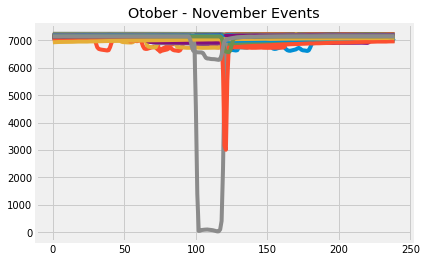

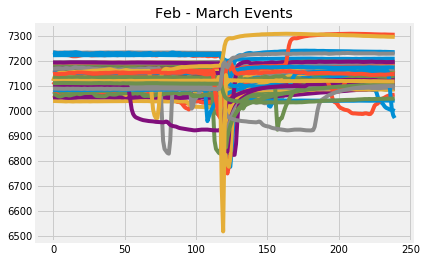

In [16]:
all_events = []; 
for i in range(len(event_times)):
    event_data = get_event(stream, event_times[i]);
    all_events.append(event_data); 
    plt.plot(event_data); 
plt.title('Otober - November Events')
    
plt.figure(); 
all_events2 = []; 
for i in range(len(event_times)):
    event_data = get_event(stream, event_times2[i]);
    all_events2.append(event_data); 
    plt.plot(event_data); 
plt.title('Feb - March Events')

In [20]:
# Optionally save events
events = np.append(all_events, all_events2, axis=0)
np.save('events_aug31', events)

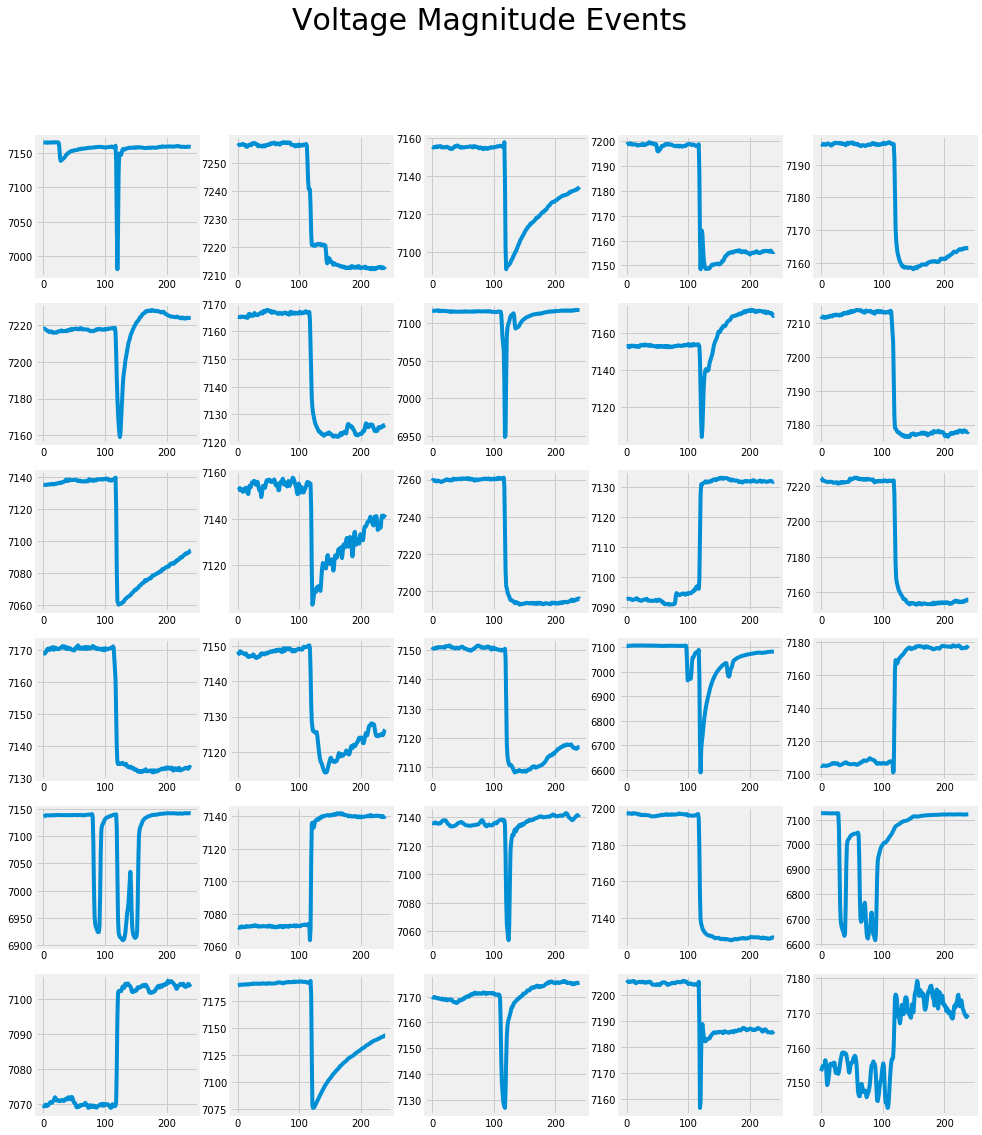

In [153]:
# Plot some of the events
N = len(all_events); 
idxs = np.arange(N); np.random.shuffle(idxs);
rows = 6; cols = 5; 
plt.figure(figsize=(cols*3, rows*3)); 
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1); 
    plt.plot(all_events[idxs[i]]);
plt.suptitle('Voltage Magnitude Events', fontsize=30);

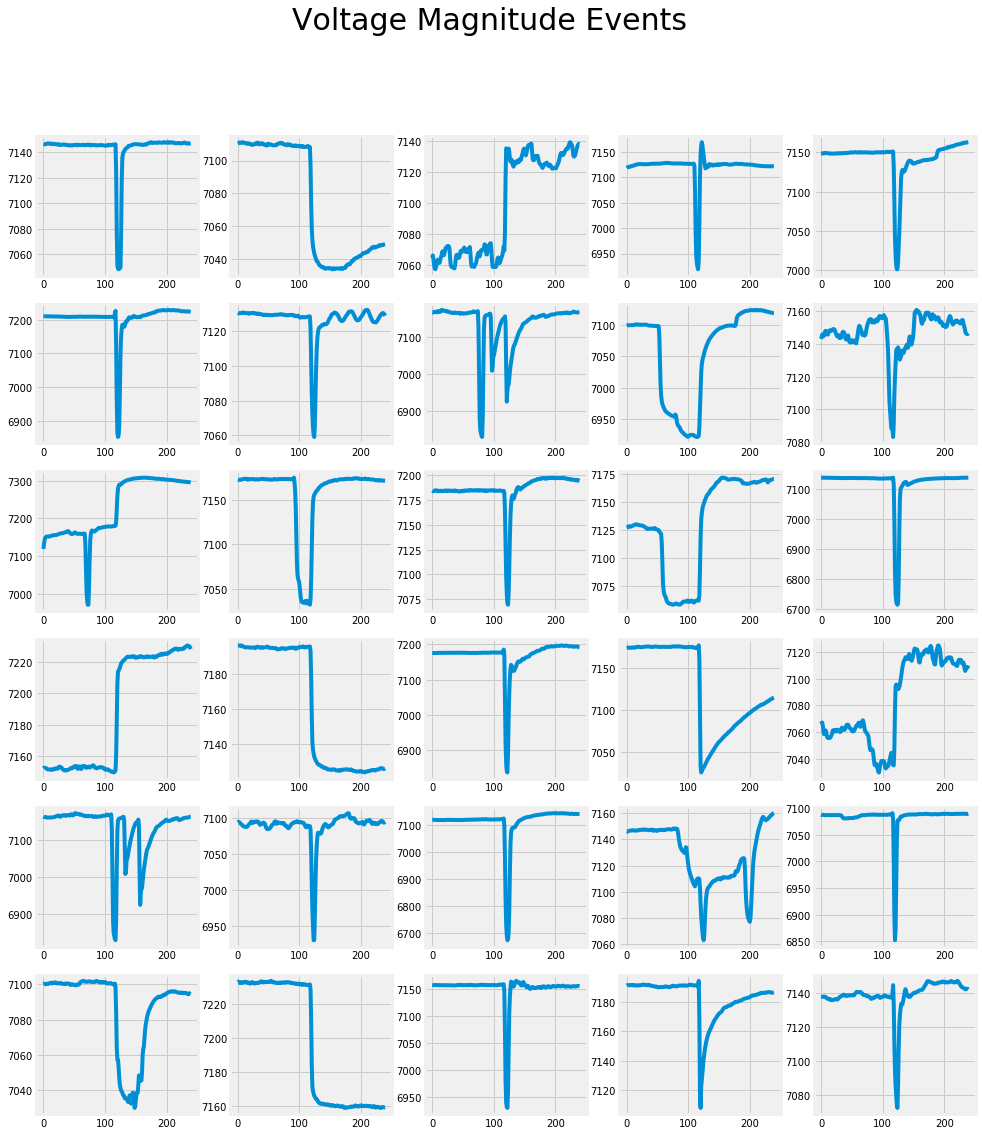

In [154]:
# Plot some of the events
N = len(all_events2); 
idxs = np.arange(N); np.random.shuffle(idxs);
rows = 6; cols = 5; 
plt.figure(figsize=(cols*3, rows*3)); 
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1); 
    plt.plot(all_events2[idxs[i]]);
plt.suptitle('Voltage Magnitude Events', fontsize=30);

# Correlations between events

In [160]:
def eventCorr(all_events):
    N = len(all_events); 
    C = np.zeros([N, N]); 
    for i in range(N):
        for j in range(N-1):
            ei = normalize(all_events[i]); 
            ej = normalize(all_events[j]); 
            C[i, j] = np.max(sig.convolve(ei, ej));
            C[j, i] = C[i, j]; 
    return C

In [161]:
C = eventCorr(all_events); 

In [203]:
C2 = eventCorr(all_events2); 

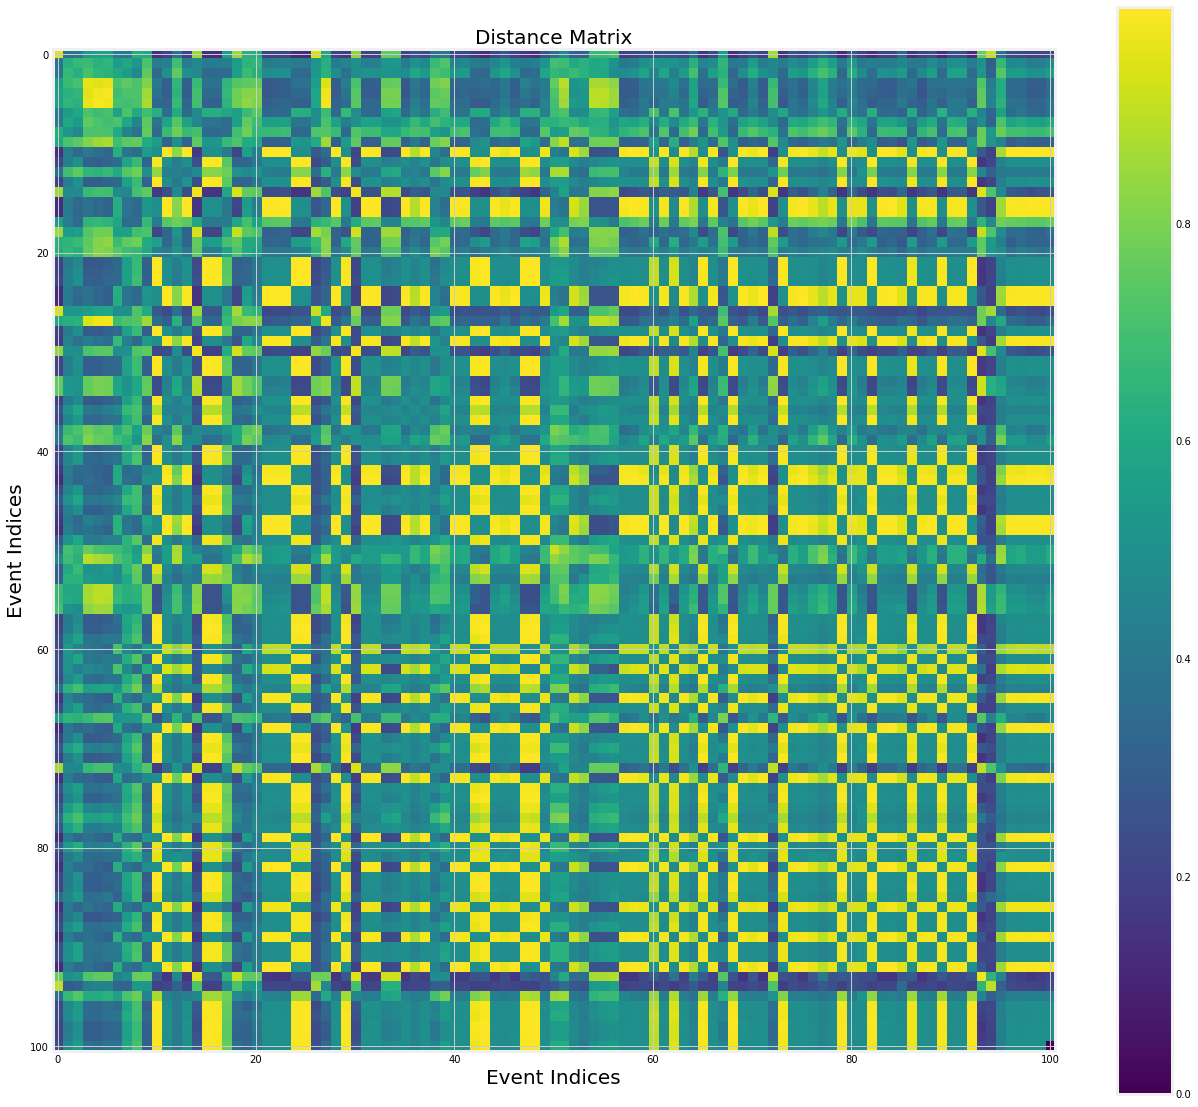

In [165]:
plt.figure(figsize=(20, 20))
plt.imshow(C); plt.colorbar();
plt.title('Distance Matrix', fontsize=20); 
plt.xlabel('Event Indices', fontsize=20);
plt.ylabel('Event Indices', fontsize=20);

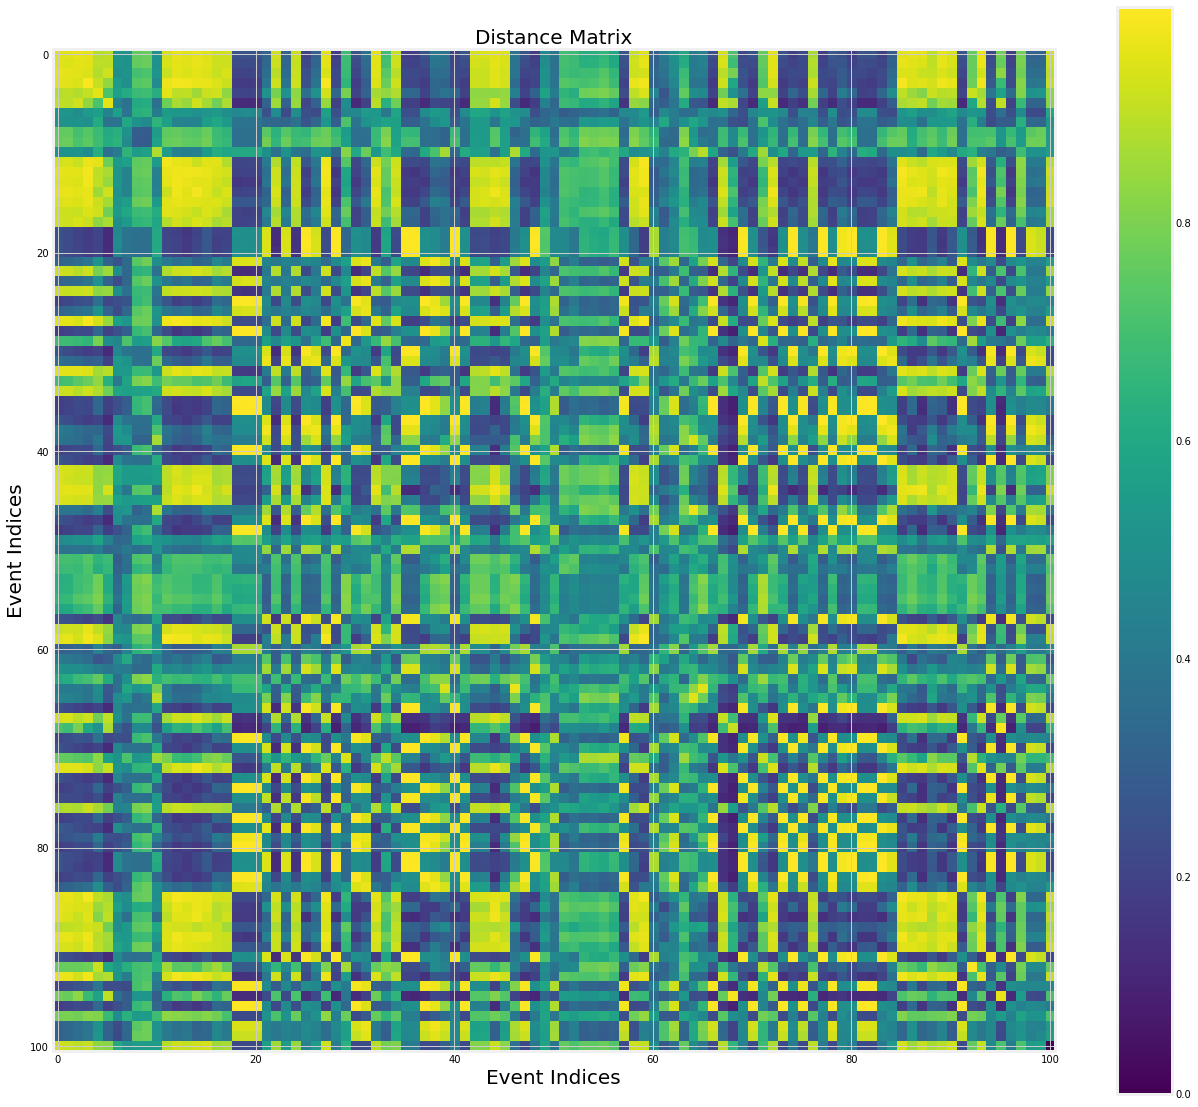

In [204]:
plt.figure(figsize=(20, 20))
plt.imshow(C2); plt.colorbar();
plt.title('Distance Matrix', fontsize=20); 
plt.xlabel('Event Indices', fontsize=20);
plt.ylabel('Event Indices', fontsize=20);

/Users/mohini/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Number of clusters:  7


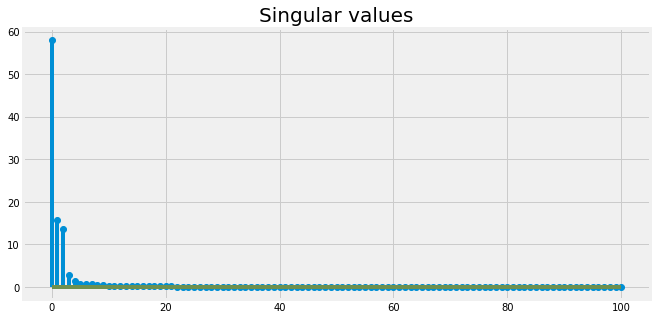

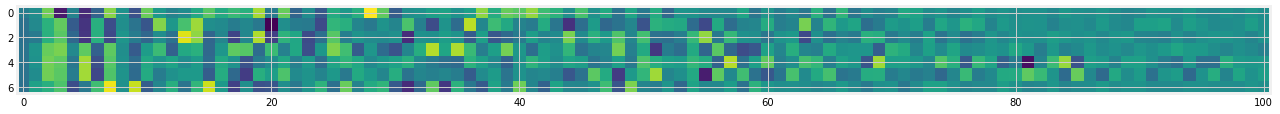

In [178]:
# Get a sense of how many clusters are needed
U, s, Vh = linalg.svd(C); 
s = np.abs(s);
plt.figure(figsize=(10, 5))
plt.stem(s); plt.title('Singular values', fontsize=20); 

max_s = np.max(s)
k_sig = np.sum(s > 0.01*max_s); 
print('Number of clusters: ', k_sig); 

# Visualize the correlations of these clusters; 
plt.figure(figsize=(20, 5)); 
plt.imshow(U[0:k_sig, :]); 

/Users/mohini/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Number of clusters:  10


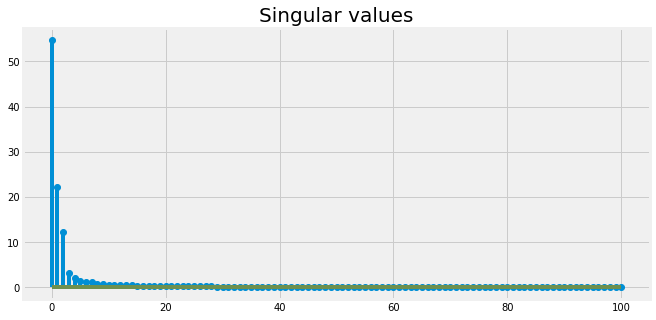

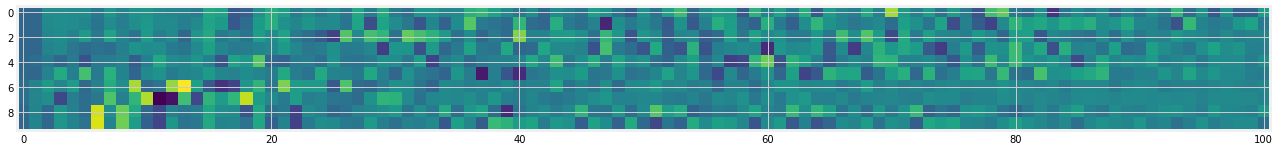

In [205]:
# Get a sense of how many clusters are needed
U, s, Vh = linalg.svd(C2); 
s = np.abs(s);
plt.figure(figsize=(10, 5))
plt.stem(s); plt.title('Singular values', fontsize=20); 

max_s = np.max(s)
k_sig = np.sum(s > 0.01*max_s); 
print('Number of clusters: ', k_sig); 

# Visualize the correlations of these clusters; 
plt.figure(figsize=(20, 5)); 
plt.imshow(U[0:k_sig, :]); 

# Experimenting with Clustering
The algorithms are from the tslearn package, which can be foud [here](https://tslearn.readthedocs.io/en/stable/index.html). 

In [180]:
# Convert the data into the time series format required by tslearn
event_data_set = tslearn.utils.to_time_series_dataset(all_events)

In [206]:
event_data_set2 = tslearn.utils.to_time_series_dataset(all_events2)

## k-shape
The choice of k (number of clusters), is based on the singular values of the correlation matrix. 

In the future, I think we will need a technique that is flexible to the choice of number of clusters. 

In [217]:
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Normalize events
event_data_set = tslearn.preprocessing.TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(event_data_set)
seed = 0
K = 15;
# kShape clustering
ks = KShape(n_clusters=K, verbose=True, random_state=seed)
y_pred = ks.fit_predict(event_data_set)

Resumed because of empty cluster
0.004 --> 0.004 --> 0.004 --> 0.004 --> 


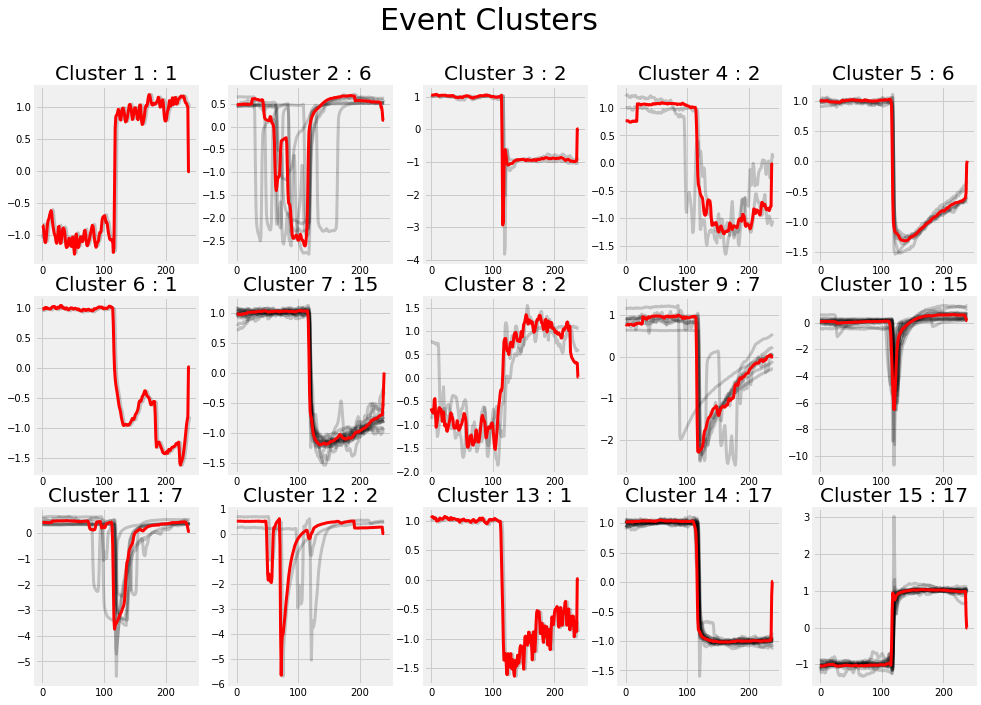

In [198]:
cols = 5; rows = int(np.ceil(K / cols)); 
plt.figure(figsize=(cols*3, rows*3 + 2))
for yi in range(K):
    plt.subplot(rows, cols, 1 + yi)
    count = 0; 
    for xx in event_data_set[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, linewidth=3)
        count += 1; 
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-", linewidth=3)
    plt.title("Cluster %d : %d" % (yi + 1, count), fontsize=20)

plt.suptitle('Event Clusters', fontsize=30);
plt.show()

In [215]:
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Normalize events
event_data_set2 = tslearn.preprocessing.TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(event_data_set2)
seed = 0
K = 20;
# kShape clustering
ks = KShape(n_clusters=K, verbose=True, random_state=seed)
y_pred = ks.fit_predict(event_data_set)

Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
0.003 --> Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 


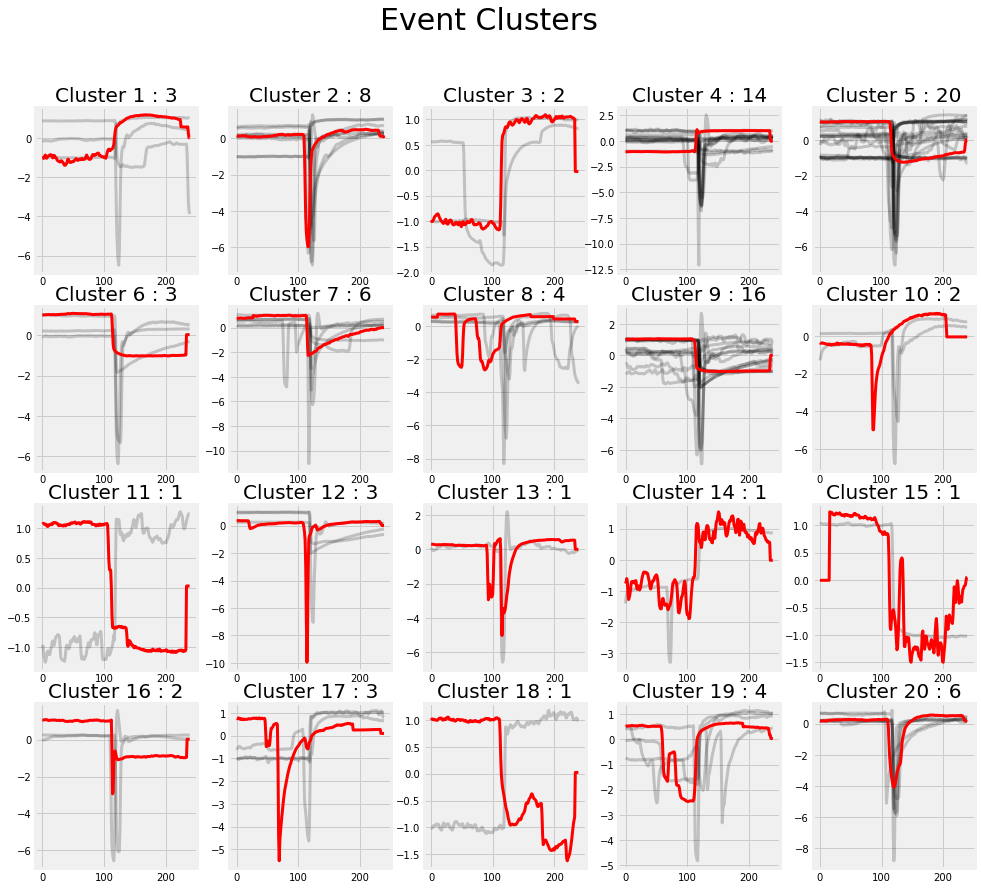

In [216]:
cols = 5; rows = int(np.ceil(K / cols)); 
plt.figure(figsize=(cols*3, rows*3 + 2))
for yi in range(K):
    plt.subplot(rows, cols, 1 + yi)
    count = 0; 
    for xx in event_data_set2[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, linewidth=3)
        count += 1; 
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-", linewidth=3)
    plt.title("Cluster %d : %d" % (yi + 1, count), fontsize=20)

plt.suptitle('Event Clusters', fontsize=30);
plt.show()

# Streaming kShape

In [29]:
import kshape
importlib.reload(kshape)

<module 'kshape' from '/Users/mohini/Documents/Google Drive/NI4AI/kshape.py'>

### Demonstration of iterative clustering. 

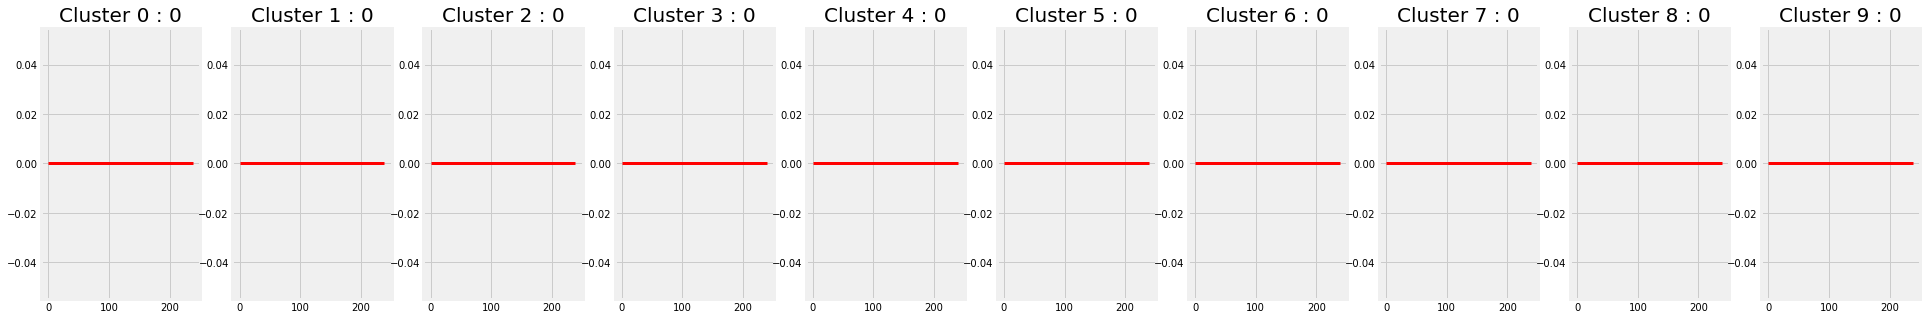

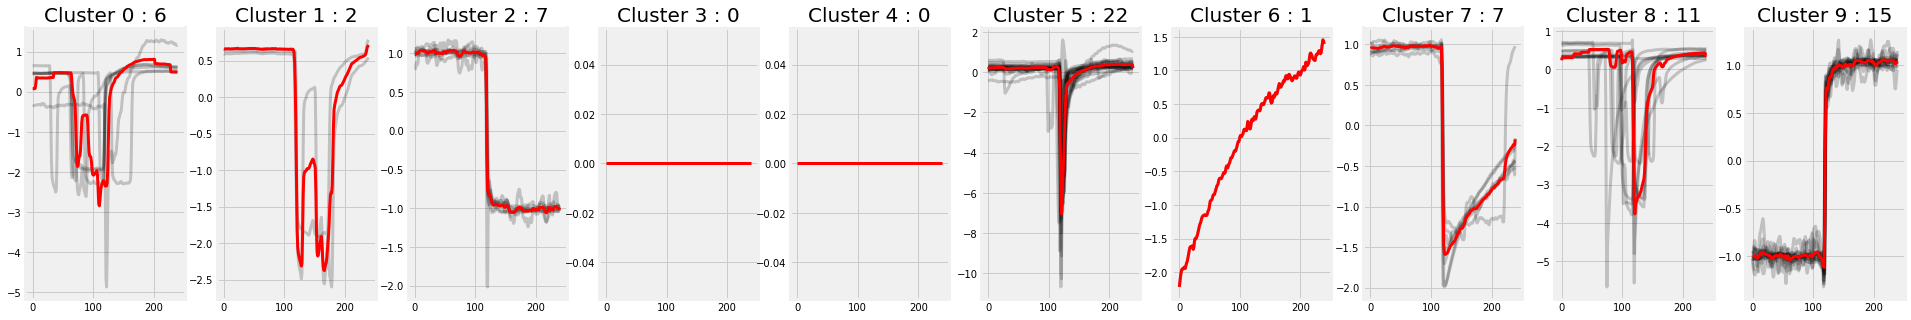

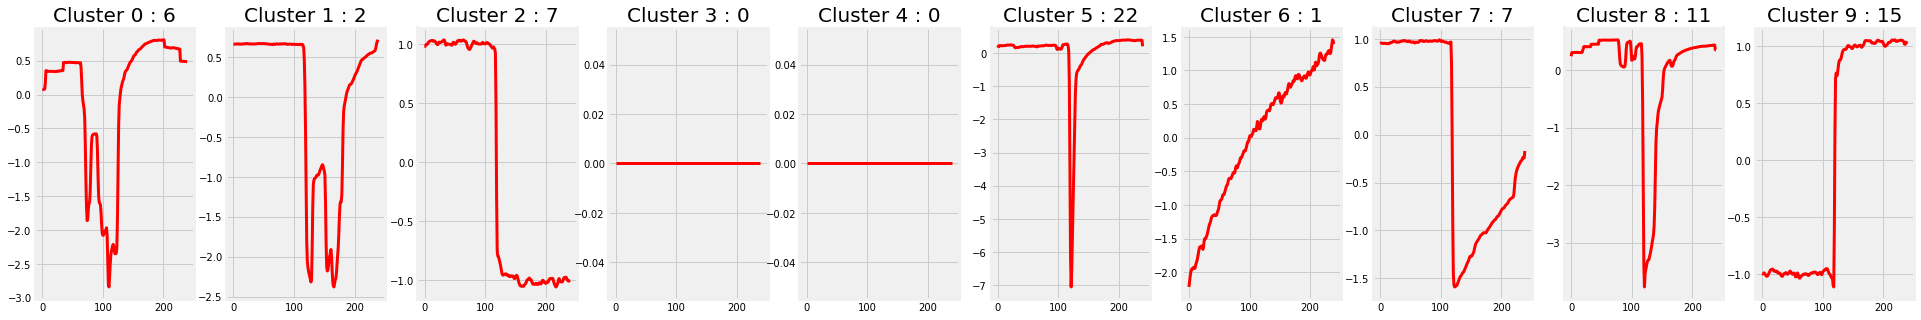

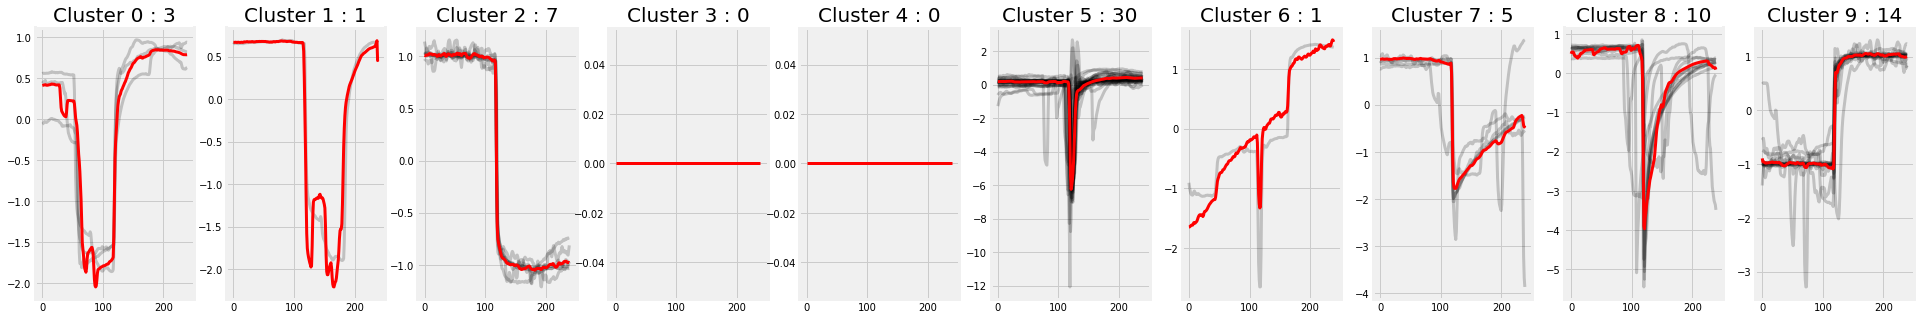

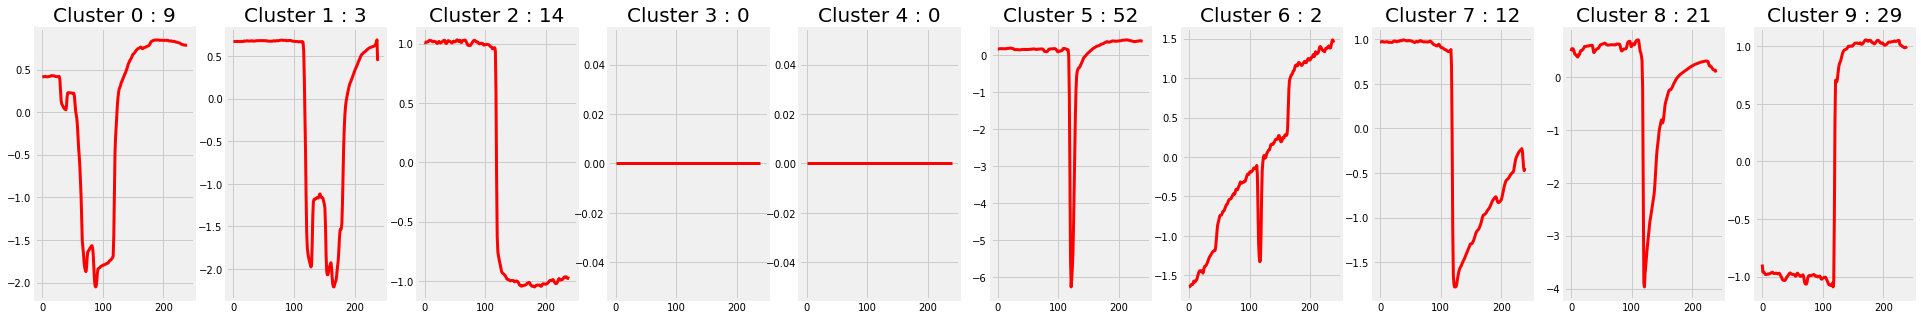

In [333]:
# Create clustering stream
kstream = kshape.kShapeStream(10, 240)
# Visualize the initial centers
kstream.visualizeCenters(cols=10); 

## Cluster first batch of events
all_events_norm = kstream.zscore(all_events, axis=1, ddof=1)
clusters = kstream.kshape(all_events_norm); 
kstream.updateClusters(clusters, all_events_norm);
kstream.init_random = False;

# Visualize first set of clusters
kstream.visualize(clusters, all_events_norm, cols=10)
kstream.visualizeCenters(cols=10);

## Cluster second batch of events
all_events_norm2 = kstream.zscore(all_events2, axis=1, ddof=1)
clusters = kstream.kshape(all_events_norm2);
kstream.updateClusters(clusters, all_events_norm);

# Visualize second set of clusters
kstream.visualize(clusters, all_events_norm2, cols=10)
kstream.visualizeCenters(cols=10); 

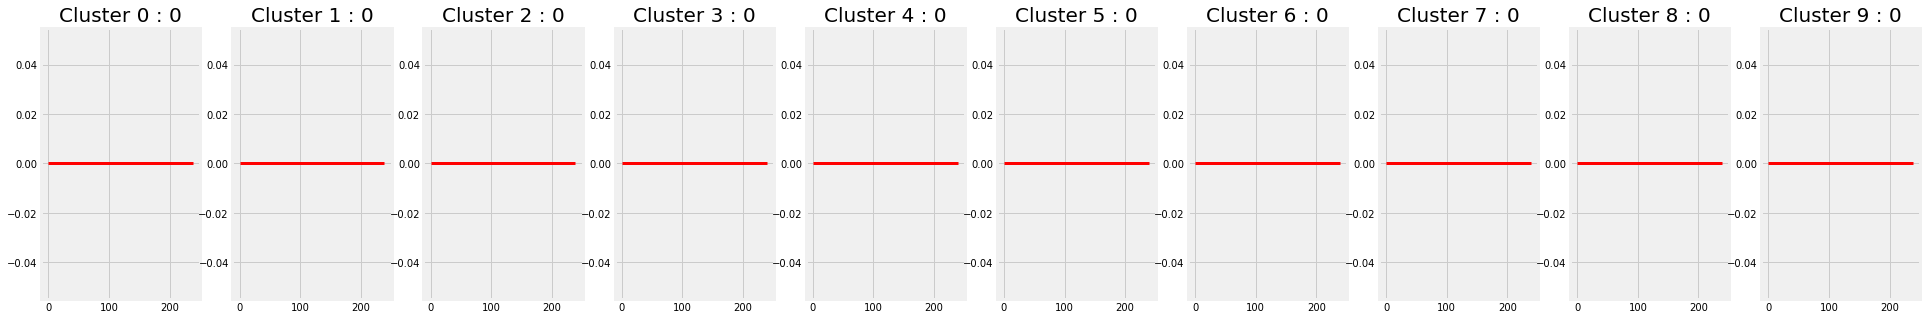

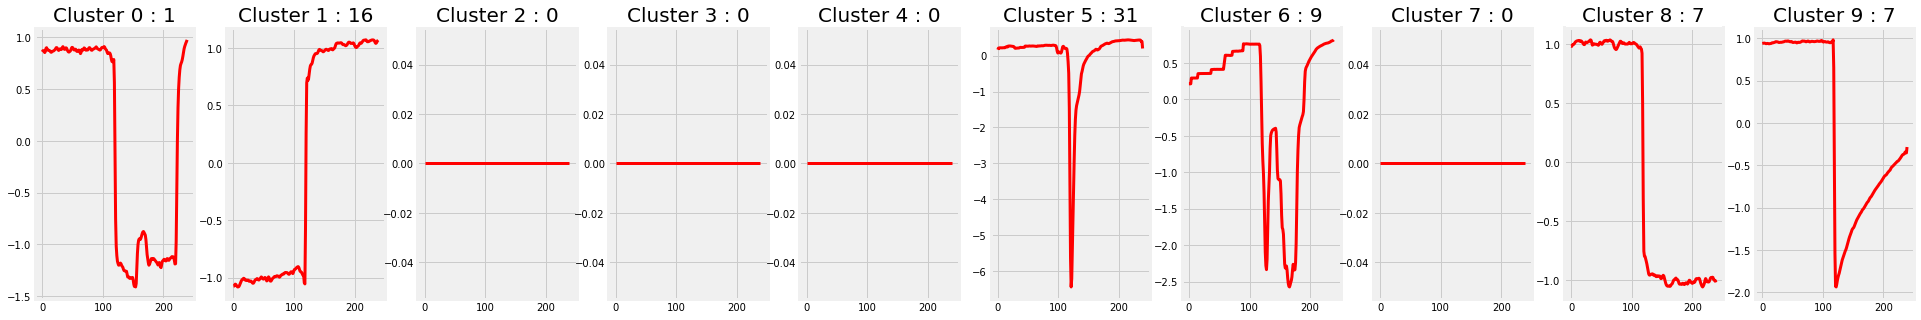

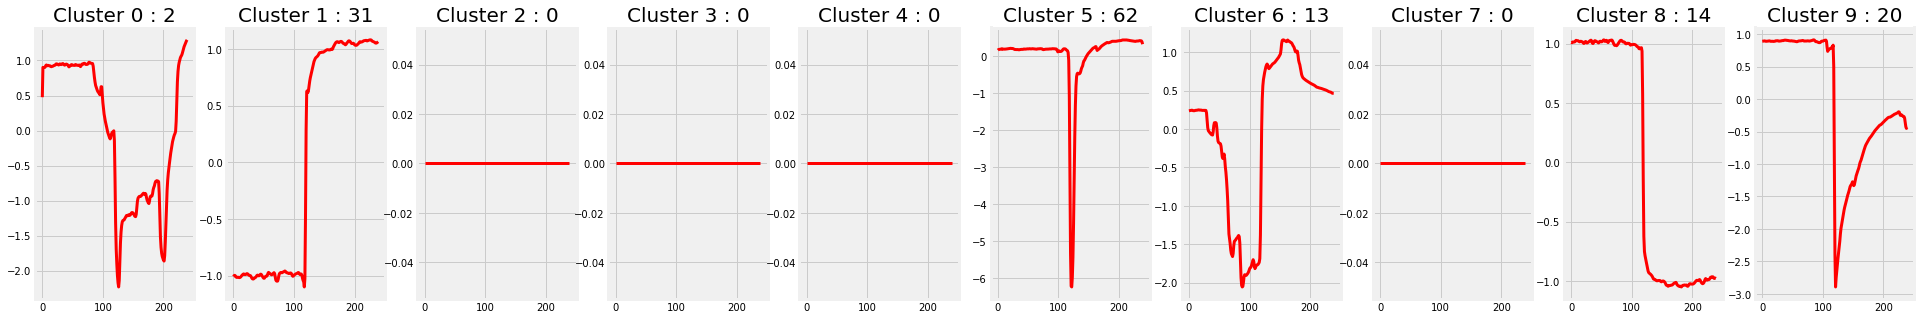

In [334]:
# Create clustering stream
kstream = kshape.kShapeStream(10, 240)
# Visualize the initial centers
kstream.visualizeCenters(cols=10); 

## Cluster first batch of events
all_events_norm = kstream.zscore(all_events, axis=1, ddof=1)
clusters = kstream.kshape(all_events_norm); 
kstream.updateClusters(clusters, all_events_norm);
kstream.init_random = False;

# Visualize first set of clusters
#kstream.visualize(clusters, all_events_norm, cols=10)
kstream.visualizeCenters(cols=10);

## Cluster second batch of events
all_events_norm2 = kstream.zscore(all_events2, axis=1, ddof=1)
clusters = kstream.kshape(all_events_norm2);
kstream.updateClusters(clusters, all_events_norm);

# Visualize second set of clusters
#kstream.visualize(clusters, all_events_norm2, cols=10)
kstream.visualizeCenters(cols=10); 

In [9]:
import kshape
importlib.reload(kshape)

<module 'kshape' from '/Users/mohini/Documents/Google Drive/NI4AI/kshape.py'>

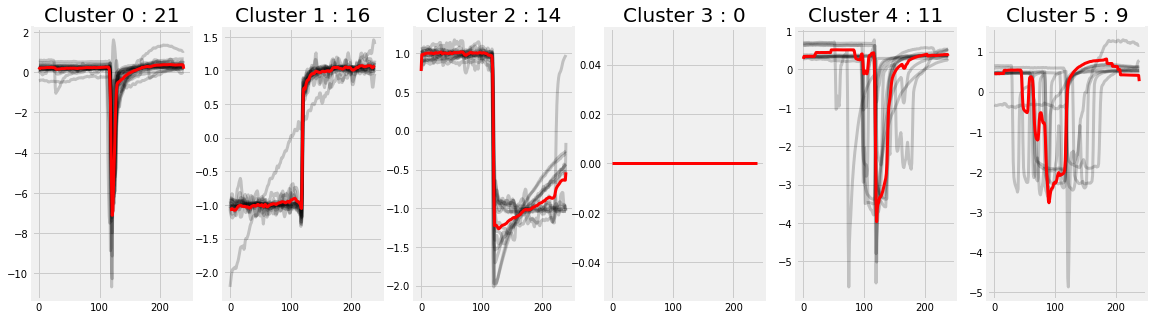

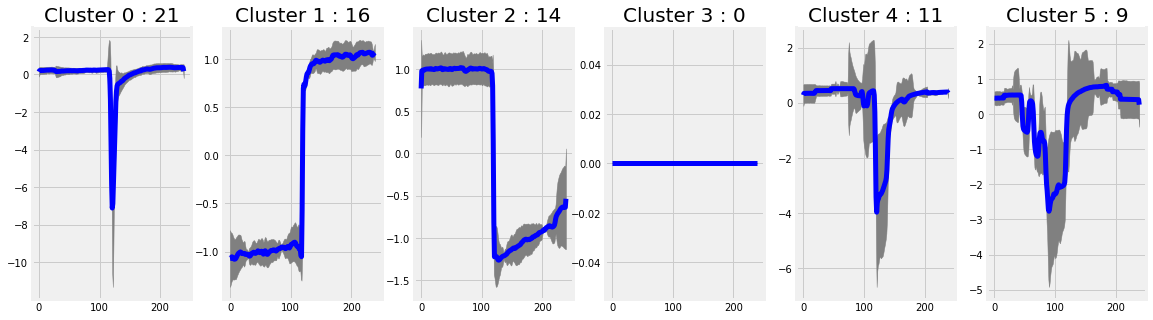

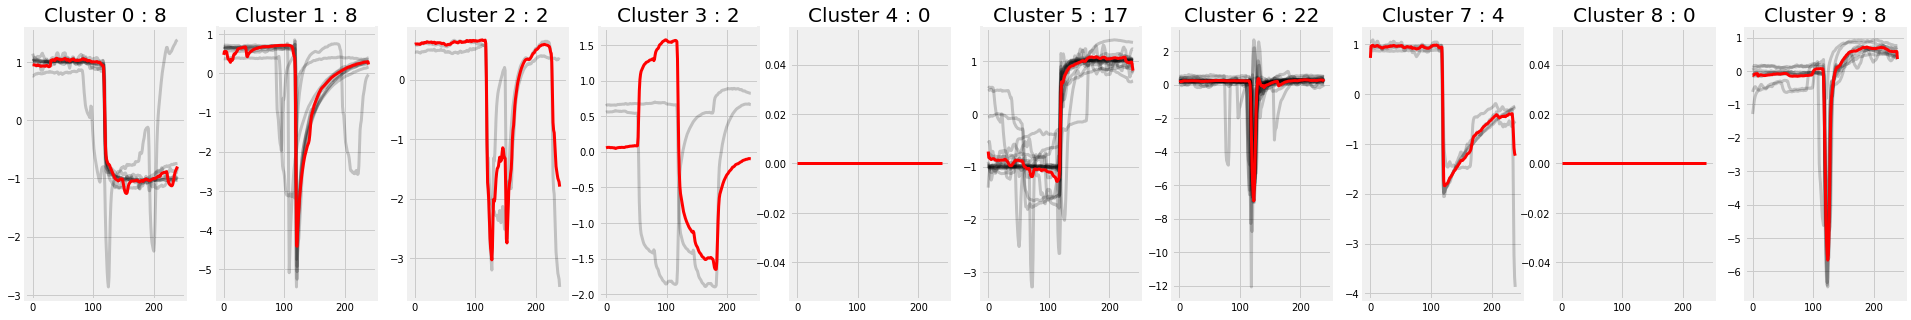

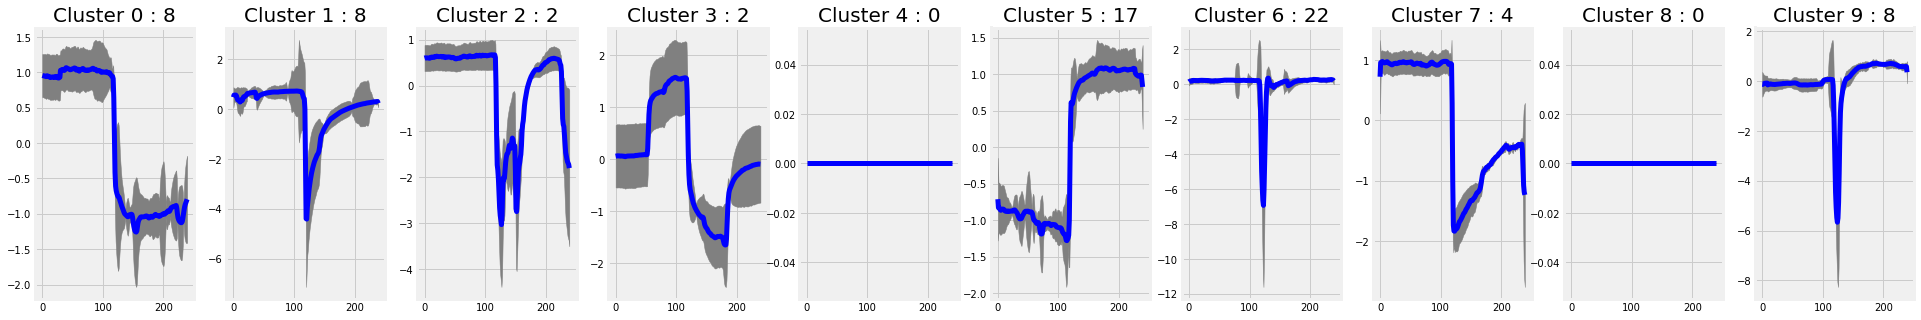

In [435]:
#### Create clustering stream
kstreamA = kshape.kShapeStream(6, 240)
# Cluster first batch of events
all_events_norm = kstreamA.zscore(all_events, axis=1, ddof=1)
clusters = kstreamA.add(all_events_norm); 
kstreamA.init_random = False;
# Visualize first set of clusters
kshape.kShapeStream.visualize(clusters, all_events_norm, cols=10)
kstreamA.visualizeCenters(cols=10)


#### Create clustering stream
kstreamB = kshape.kShapeStream(10, 240)
## Cluster second batch of events
all_events_norm2 = kstreamB.zscore(all_events2, axis=1, ddof=1)
clusters = kstreamB.add(all_events_norm2);
#kstreamB.updateClusters(clusters, all_events_norm);
# Visualize second set of clusters
kshape.kShapeStream.visualize(clusters, all_events_norm2, cols=10)
kstreamB.visualizeCenters(cols=10)

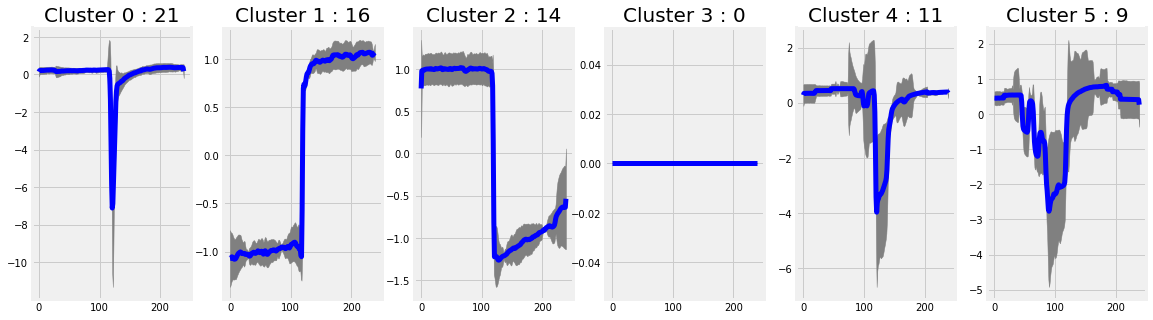

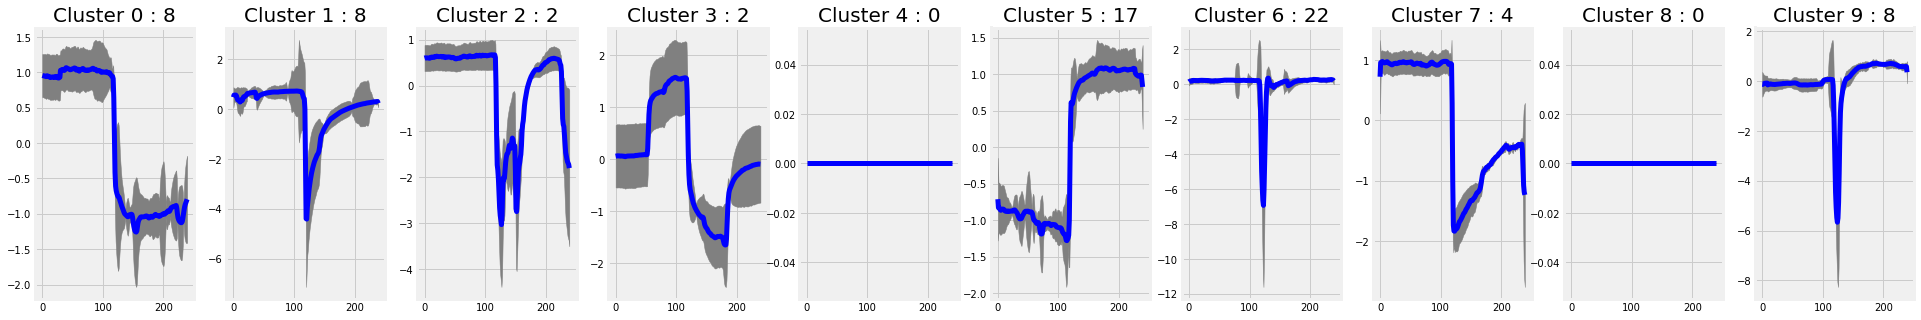

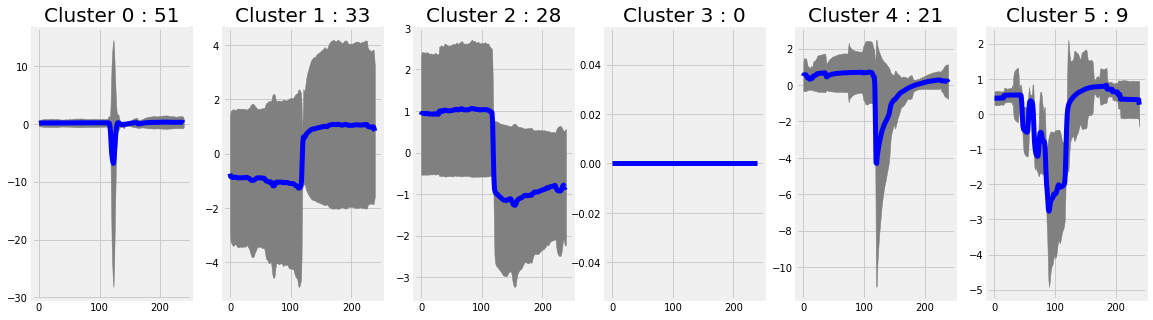

In [436]:
# Combine
kstreamA.visualizeCenters(cols=10); 
kstreamB.visualizeCenters(cols=10);
clusters_comb = kstreamA.add(kstreamB);
kstreamA.visualizeCenters(cols=10);

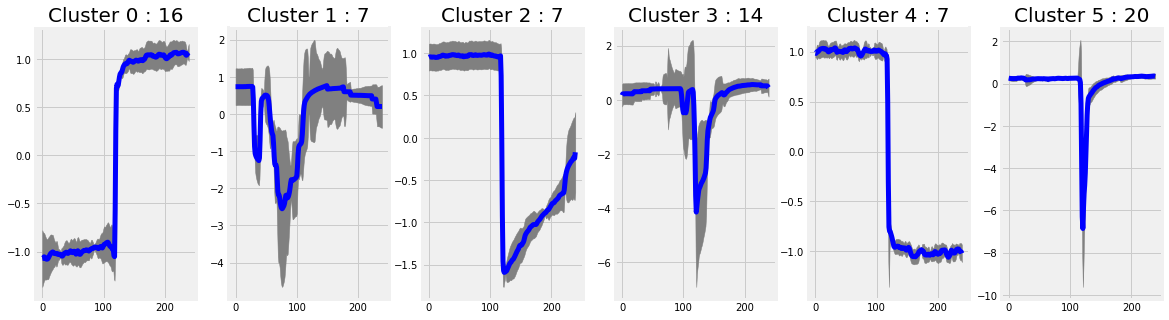

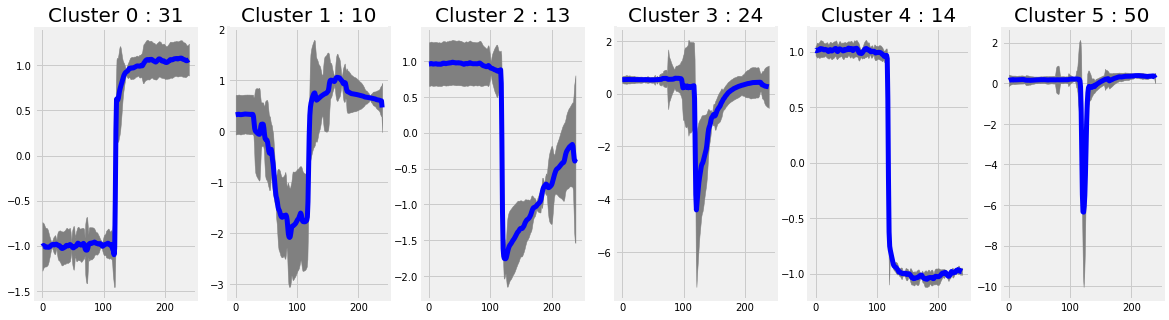

In [437]:
#### Create clustering stream
kstream = kshape.kShapeStream(6, 240)

all_events_norm = kstream.zscore(all_events, axis=1, ddof=1)
all_events_norm2 = kstream.zscore(all_events2, axis=1, ddof=1)

kstream.add(all_events_norm); 
kstream.visualizeCenters(cols=6);
kstream.add(all_events_norm2); 
kstream.visualizeCenters(cols=6);

# Over a longer time horizon
Let us see how clusters evolve over a longer time horizon. 

In [17]:
def long_clustering(stream, start, end, dt, k=6, thresh=0.01):
    # Inform which stream we are searching in
    print('Clustering events in: ', stream.collection, stream.name);
    
    # Initialize clustering stream
    kstream = kshape.kShapeStream(k, 240)
    
    cur_start = start; 
    cur_end = cur_start + dt
    while cur_end < end:
        
        # Find event times
        print('Finding events between: ', ns_to_datetime(cur_start), ns_to_datetime(cur_end))
        edges = find_edges_dfs(stream, thresh, start=cur_start, end=cur_end, vnom=vnom); 
        event_times = getEventTimes(edges); 
        
        # Get event data
        print('Getting event data')
        events = []; 
        for i in range(len(event_times)):
            event_data = get_event(stream, event_times[i]);
            events.append(event_data); 
        events = np.array(events); 
        print('Number of events: ', events.shape[0])
        
        # Normalize events
        events = kstream.zscore(events, axis=1, ddof=1)
        
        # Visualize
        print('Clustering events'); 
        kstream.add(all_events_norm); 
        kstream.visualizeCenters(cols=k);
        
        cur_start = cur_end; 
        cur_end = cur_start + dt; 

In [18]:
# stream
stream = streams["0295f80f-6776-4384-b563-4582f7256600"];
print(stream.collection, stream.name)
vnom = get_mean_value(stream); 
thresh = 0.01; 

# october 12, 2015 - june 3, 2016
# uninterrupted measurements
start = to_nanoseconds("2015-10-12T00:00:00.000Z")
end = to_nanoseconds("2016-06-03T00:00:00.000Z")
dt = ns_delta(days=28); 

edges = find_edges_dfs(stream, thresh, start=start, end=end, vnom=vnom); 
event_times = getEventTimes(edges); 

events = []; 
for i in range(len(event_times)):
    event_data = get_event(stream, event_times[i]);
    events.append(event_data); 
    
print(np.shape(events))

sunshine/PMU3 L1MAG
(101, 240)


In [19]:
stream = streams["0295f80f-6776-4384-b563-4582f7256600"];
# october 12, 2015 - june 3, 2016
# uninterrupted measurements
start = to_nanoseconds("2015-10-12T00:00:00.000Z");
end = to_nanoseconds("2016-02-12T00:00:00.000Z");
#end = to_nanoseconds("2016-06-03T00:00:00.000Z")
dt = ns_delta(days=28);

long_clustering(stream, start, end, dt)

Clustering events in:  sunshine/PMU3 L1MAG
Finding events between:  2015-10-12 00:00:00+00:00 2015-11-09 00:00:00+00:00
Getting event data
Number of events:  101
Clustering events


NameError: name 'all_events_norm' is not defined

# Questions & Thoughts
1. How important is alignment? Should we 'align' all the time series to begin with (centering the point of maximum change?)
2. How important is the actual clustering? Can we simply add points to the nearest cluster? In this case, the main value of kShape would be the shape extraction. Would this amount to the "classification" approach?

In [12]:
kstream = kshape.kShapeStream(5, 240); 
X = np.random.rand(100, 240); 
y = np.random.rand(10, 240); 
d = kstream.ncc_c_3dim(X, y).max(axis=2)

In [14]:
print(np.shape(d))

(10, 100)
